In [1]:
# Define a function that generates samples approximate RGO. The target is defined in Potential class.
import numpy as np
import matplotlib.pyplot as plt
import targets
import cProfile
import pstats
import random
import argparse
import os
from utils import target_func, mixing_time, TV_estimation, target_funnel
import matplotlib.ticker as ticker



In [2]:

# Define a function as the original approximate RGO
def generate_samples(step_size, x_y, f):
    dimension = f.dimension
    ite = 0
    while True:
        samples = np.random.multivariate_normal(mean = x_y, cov = step_size * np.identity(dimension), size = 2)
        # Compute the acceptance probability
        gradient = f.firstOrder(x_y)
        a = f.zeroOrder(samples[0,:])-np.dot(gradient,samples[0,:])
        b = f.zeroOrder(samples[1,:])-np.dot(gradient,samples[1,:])
        # The code works even when rho is inf. One can also take the log transformation
        rho = np.exp(b-a)
        u = np.random.uniform(0,1)
        ite = ite + 1
        if u < rho/2:
            break
    return samples[0,:],ite

# Define a function that estimates the local step size
def estimate_step_size(step_size, tolerance, y, f):
    dimension = f.dimension
    # Compute the desired subexponential parameter
    x_y = f.solve1(y, step_size)
    testFunction = lambda C : np.mean(np.exp(np.abs(Y)**(2/(1+f.alpha))/C))-2
    while True:
        # Generate random samples from a Gaussian distribution: \exp^{-(x-x_y)^2/(2\step_size)}
        samples = np.random.multivariate_normal(mean = x_y, cov = step_size * np.identity(dimension), size = 200)
        Y = np.zeros(100)
        for i in range(100):
            gradient = f.firstOrder(x_y)
            a = f.zeroOrder(samples[i])-np.dot(gradient,samples[i])
            b = f.zeroOrder(samples[i+100])-np.dot(gradient,samples[i+100])
            Y[i] = b-a
        # Estimate the subexponential parameter of Y: find the smallest C>0 such that E[\exp^{\abs(Y)/C}] \leq 2 by binary search for smooth potentials
        # Initialize the interval
        left = 0
        right = dimension**(f.alpha/(f.alpha+1)) # The estimated upper bound of the subexponential parameter
        while testFunction(right)>0:
            left = right
            right = 2*right
        # Initialize the middle point
        mid = (left+right)/2
        # Initialize the value of the function
        f_mid = testFunction(mid)
        while abs(f_mid) > 1e-2:
            if f_mid > 0:
                left = mid
            else:
                right = mid
            mid = (left+right)/2
            f_mid =  testFunction(mid)
        if mid < 1 / ( np.log(6/tolerance) / np.log(2)  * 0.05) :
            break
        else:
            step_size = step_size / 2
            x_y = f.solve1(y, step_size)
    return step_size, x_y

# Define the outer loop of proximal sampler
def proximal_sampler(initial_step_size, num_samples, num_iter, f, fixed):
    dimension = f.dimension

    samples = np.zeros([num_samples,num_iter,dimension])
    Ysamples = np.zeros([num_samples,dimension])
    rejections = np.zeros([num_samples, num_iter])
    step_sizes = np.zeros([num_samples,num_iter])

    # Initialize the samples for both fxied and adaptive versions
    samples[:,0,:] = np.random.multivariate_normal(mean = 2 + np.zeros(dimension), cov = np.identity(dimension), size = num_samples)
    for j in range(num_samples):
        Ysamples[j,:] = np.random.multivariate_normal(mean =  np.zeros(dimension), cov = np.identity(dimension), size = 1)
        if fixed == False:
            step_size, x_y = estimate_step_size(initial_step_size, 1e-2, Ysamples[j,:], f)
            step_sizes[j,0] = step_size
    
    if fixed == True:    
        print(f'fixed sampling')
        for i in range(1,num_iter):
            for j in range(num_samples):
                x_y = f.solve1(Ysamples[j,:], initial_step_size)
                samples[j,i,:],ite = generate_samples(initial_step_size, x_y, f)
                Ysamples[j,:] = np.random.multivariate_normal(mean = samples[j,i,:], cov = initial_step_size * np.identity(dimension), size = 1) 
                rejections[j,i] = ite
            if i % 100 == 0:
                print(f"Steps:{i}")
                if f.times2 > 0:
                    print(f"Averaged optimization steps of the new one: {f.ite2/f.times2}")
                print(f"Averaged rejection steps : {np.mean(rejections[:,i])}")
        
        return samples
    
    if fixed == False:
        print(f'adpative sampling')
        for i in range(1,num_iter):
            for j in range(num_samples):
                # if i < 100 or (i >= 100 and np.random.uniform(0,1) < 0.001):
                if True:
                    step_size, x_y = estimate_step_size(2*step_sizes[j,i-1], 1e-2, Ysamples[j,:], f)
                else:
                    x_y = f.solve1(Ysamples[j,:], step_sizes[j,i-1])
                    step_size = step_sizes[j,i-1]
                samples[j,i,:],ite = generate_samples(step_size, x_y, f)
                Ysamples[j,:] = np.random.multivariate_normal(mean = samples[j,i,:], cov = step_size * np.identity(dimension), size = 1)  
                step_sizes[j,i] = step_size
                rejections[j,i] = ite  
            
            # statistics for the first sample
            if i % 100 == 0:
                print(f"Steps:{i}")
                print(f"Averaged_step_size:{np.mean(step_sizes[:,i])}")
                if f.times2 > 0:
                    print(f"Averaged optimization steps of the new one: {f.ite2/f.times2}")
                print(f"Averaged rejection steps : {np.mean(rejections[:,i])}")
    return samples, step_sizes
            

def MALA(Target, eta, num_iter, numSamplers):
    Xsamples = np.zeros([numSamplers, num_iter,Target.dimension])
    Xsamples[:, 0,:] = np.random.multivariate_normal(mean = np.zeros(Target.dimension), cov = np.identity(Target.dimension), size = numSamplers)
    for j in range(numSamplers):
        for i in range(num_iter-1):
            standard_Gaussian = np.random.multivariate_normal(mean = np.zeros(Target.dimension), cov = np.identity(Target.dimension), size = 1)
            x = Xsamples[j,i,:]
            y = x - eta*Target.firstOrder(x) + np.sqrt(2*eta)*standard_Gaussian
            y = y.ravel()
            tempxy = x - y + eta * Target.firstOrder(y)
            pxy = np.exp(-np.dot(tempxy, tempxy)/(4*eta))
            tempyx = y - x + eta * Target.firstOrder(x)
            pyx = np.exp(-np.dot(tempyx, tempyx)/(4*eta))
            r1 = Target.density(y)/Target.density(x)
            r2 = pxy/pyx
            acc_prob = min(1,r1*r2)
            U = np.random.uniform(0,1)
            if U <= acc_prob:
                x = y
            Xsamples[j,i+1,:] = x
    return Xsamples


In [ ]:
# def Gaussian_sampler(seed, dimension, numIter, numSamples, initialStep):

#     random.seed(seed)
#     np.random.seed(seed)

#     Target = target_func(dimension, if_simple = True)
    
#     # To Do: double check this formula
#     hatC = (1+Target.alpha)*(1/Target.alpha)**(Target.alpha/(1+Target.alpha))*(1/np.pi)**(2/(1+Target.alpha))*2**((-1-2*Target.alpha)/(1+Target.alpha))
#     min_step_size = hatC/(120*np.log(6/0.01)/np.log(2)*Target.L_alpha*np.sqrt(Target.dimension))
#     print(f"min_step_size={min_step_size}")
    
#     # step size = 0.1 is good enough
#     # RGO with fixed step size, the initial large one
    
#     Xsamples_fixed_1 = proximal_sampler(10, numSamples, numIter, f = Target, fixed = True) 
#     Xsamples_fixed_2 = proximal_sampler(1, numSamples, numIter, f = Target, fixed = True) 
#     Xsamples_fixed_3 = proximal_sampler(0.1, numSamples, numIter, f = Target, fixed = True) 
#     Xsamples_adaptive ,step_sizes = proximal_sampler(initialStep, numSamples, numIter, f = Target, fixed = False)
    
#     Xsamples_MALA_1 = MALA(Target, 10, numIter, numSamples)
#     Xsamples_MALA_2 = MALA(Target, 1, numIter, numSamples)
#     Xsamples_MALA_3 = MALA(Target, 0.1, numIter, numSamples)
    
#     plt.plot(np.log(np.mean(step_sizes,axis=0)))
#     plt.title('Mean of the step_size')
#     plt.savefig('step_size.png')
#     plt.close()
    
#     direction = np.random.multivariate_normal(mean = np.zeros(dimension), cov =  np.identity(dimension), size = 1)
#     direction = np.transpose(direction) / np.linalg.norm(direction, ord = 2)
#     # 0. True density
#     realSamples = np.zeros([200000, dimension])
#     for i in range(np.shape(realSamples)[0]):
#             realSamples[i,:] = Target.samplesTarget()
#     bin_num = 500
#     plt.hist(np.matmul(realSamples,direction), bins=bin_num, edgecolor='black', density=True, fill=False)
#     plt.savefig(f"true_density.png")
#     plt.close()
    
#     # 2.1 Discrete TV on a random direction 
#     num_iter = numIter
#     number_samples_hist = int(0.2 * num_iter)
#     min_number_samples_hist = int(0.1 * num_iter)
#     number_hist = 100
#     # Not the precise bin_size but it doesn't matter
#     bin_size = int((number_samples_hist-min_number_samples_hist) / 100 )
#     index_hist = np.linspace(number_samples_hist, num_iter, number_hist)
#     index_hist = index_hist.astype(int)
    
#     projected_sample = np.matmul(realSamples,direction)
#     histY, bin_edges_Y = np.histogram(projected_sample, bins=bin_num, density=True)
    
    
#     plt.figure(figsize=(5,7.5))
    
#     distances_random = np.zeros(number_hist)
#     projected_sample_random = np.matmul(Xsamples_fixed_1,direction)
#     for i in range(number_hist):
#         distances_random[i] = TV_estimation(projected_sample_random[0,min_number_samples_hist:index_hist[i]], histY, bin_edges_Y, bin_num)
#     plt.plot(index_hist,0.5*distances_random, label = 'PS, step size 10')
    
#     distances_random = np.zeros(number_hist)
#     projected_sample_random = np.matmul(Xsamples_fixed_2,direction)
#     for i in range(number_hist):
#         distances_random[i] = TV_estimation(projected_sample_random[0,min_number_samples_hist:index_hist[i]], histY, bin_edges_Y, bin_num)
#     plt.plot(index_hist, 0.5*distances_random, label = 'PS, step size 1')
    
#     distances_random = np.zeros(number_hist)
#     projected_sample_random = np.matmul(Xsamples_fixed_3,direction)
#     for i in range(number_hist):
#         distances_random[i] = TV_estimation(projected_sample_random[0,min_number_samples_hist:index_hist[i]], histY, bin_edges_Y, bin_num)
#     plt.plot(index_hist, 0.5*distances_random, label = 'PS, step size 0.1')
    
#     distances_random = np.zeros(number_hist)
#     projected_sample_random = np.matmul(Xsamples_adaptive,direction)
#     for i in range(number_hist):
#         distances_random[i] = TV_estimation(projected_sample_random[0,min_number_samples_hist:index_hist[i]], histY, bin_edges_Y, bin_num)
#     plt.plot(index_hist, 0.5*distances_random, label = 'adpative, intial 10')
    
#     distances_random = np.zeros(number_hist)
#     projected_sample_random = np.matmul(Xsamples_MALA_1,direction)
#     for i in range(number_hist):
#         distances_random[i] = TV_estimation(projected_sample_random[0,min_number_samples_hist:index_hist[i]], histY, bin_edges_Y, bin_num)
#     plt.plot(index_hist, 0.5*distances_random, linestyle='dashed', label = 'MALA, step size 10')
    
    
#     distances_random = np.zeros(number_hist)
#     projected_sample_random = np.matmul(Xsamples_MALA_2,direction)
#     for i in range(number_hist):
#         distances_random[i] = TV_estimation(projected_sample_random[0,min_number_samples_hist:index_hist[i]], histY, bin_edges_Y, bin_num)
#     plt.plot(index_hist, 0.5*distances_random, linestyle='dashed', label = 'MALA, step size 1')
    
    
#     distances_random = np.zeros(number_hist)
#     projected_sample_random = np.matmul(Xsamples_MALA_3,direction)
#     for i in range(number_hist):
#         distances_random[i] = TV_estimation(projected_sample_random[0,min_number_samples_hist:index_hist[i]], histY, bin_edges_Y, bin_num)
#     plt.plot(index_hist, 0.5*distances_random, linestyle='dashed', label = 'MALA, step size 0.1')
    
    
#     plt.xlabel('Iterations')
#     plt.ylabel('TV along a random direction')
#     plt.legend(fontsize = 'small', loc = 'lower left')
#     plt.savefig(f'{seed}_Gaussian.pdf')
#     plt.show()
#     plt.close()
#     if Target.times1 > 0:
#         print(f"# of calls of built-in: {Target.times1}")
#     if Target.times2 > 0:
#         print(f"Averaged optimization steps of the new one: {Target.ite2/Target.times2}")
#         print(f"# of calls of the new one: {Target.times2}")
#     print(f"dimension:{dimension}")
#     print(f"alpha:{Target.alpha}")
#     # print(f"length:{Target.components}")
#     # print(f"eigenvalues:{1/max(eigenvalues)} and {1/min(eigenvalues)}")
    
#     return step_sizes

# step_sizes = Gaussian_sampler(0, 50, 400, 1, 10)
# step_sizes = step_sizes[0,:]
# plt.figure(figsize=(5,7.5))
# print(step_sizes)
# plt.plot(step_sizes)
# plt.xlabel('Iterations')
# plt.ylabel('Step size')
# plt.yscale('log')
# plt.axhline(y=0.625,linestyle = '--', label = '0.625', color = 'r')
# plt.axhline(y=0.3125,linestyle = '--', label = '0.3125', color = 'g')
# plt.legend()
# plt.savefig(f'{0}_size.pdf')
# plt.show()
# plt.close()
# # more challenging target has a large K and hence more iterations for the optimization. Guassina results
# # we can show the change of estimated step size verses L

In [ ]:
# dimension = 2
# y  = np.random.multivariate_normal(mean = np.zeros(dimension), cov = np.identity(dimension), size = 1)  
# y = y[0,:]
# f = target_func(dimension, if_simple = True)
# # Compute the desired subexponential parameter
# step_size = 0.3125
# x_y = f.solve1(y, step_size)
# samples = np.random.multivariate_normal(mean = x_y, cov = step_size * np.identity(dimension), size = 200)
# Y = np.zeros(100)
# for i in range(100):
#     gradient = f.firstOrder(x_y)
#     a = f.zeroOrder(samples[i])-np.dot(gradient,samples[i])
#     b = f.zeroOrder(samples[i+100])-np.dot(gradient,samples[i+100])
#     Y[i] = b-a
# means = np.zeros(100)
# C = step_size * np.sqrt(2) * 1 * 10
# for i in range(100):
#     temp = Y[0:i]
#     means[i] = np.mean(np.exp(np.abs(temp)**(2/(1+f.alpha))/C))
# plt.plot(means)
# plt.show()

L=1.0
min_step_size=0.00014371191339995835
fixed sampling
Steps:100
Averaged rejection steps : 2.0
Steps:200
Averaged rejection steps : 1.0
Steps:300
Averaged rejection steps : 1.0
fixed sampling
Steps:100
Averaged rejection steps : 2.0
Steps:200
Averaged rejection steps : 1.0
Steps:300
Averaged rejection steps : 2.0
fixed sampling
7.504626239756855e-08
Steps:100
Averaged rejection steps : 3.0
Steps:200
Averaged rejection steps : 1.0
Steps:300
Averaged rejection steps : 1.0
adpative sampling
Steps:100
Averaged_step_size:0.625
Averaged rejection steps : 2.0
Steps:200
Averaged_step_size:0.625
Averaged rejection steps : 2.0
Steps:300
Averaged_step_size:0.625
Averaged rejection steps : 4.0
3.7818307089907555e-08
L=1.0
min_step_size=0.00014371191339995835
fixed sampling
Steps:100
Averaged rejection steps : 1.0
Steps:200
Averaged rejection steps : 2.0
3.974017620960376e-06
Steps:300
Averaged rejection steps : 3.0
fixed sampling
Steps:100
Averaged rejection steps : 1.0
Steps:200
Averaged reje

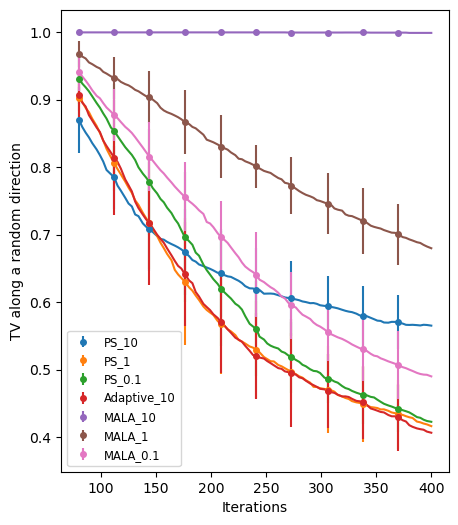

max of std size:0.3125


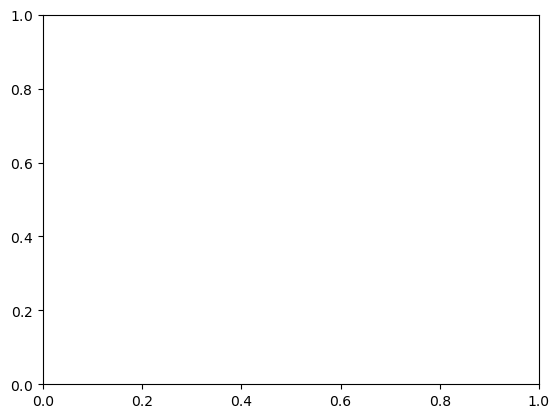

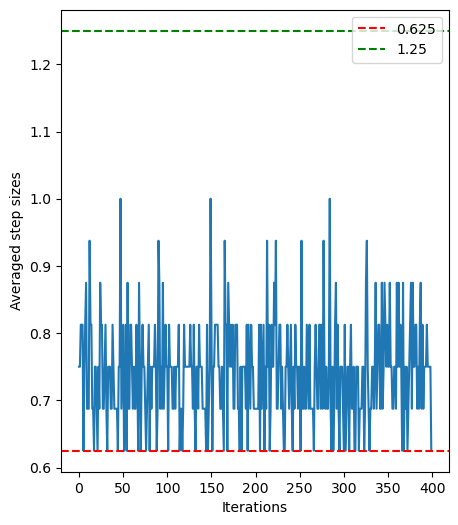

In [5]:

def Gaussian_sampler(seed, dimension, numIter, numSamples, initialStep):
    random.seed(seed)
    np.random.seed(seed)

    Target = target_func(dimension, if_simple=True)
    
    # To Do: double check this formula
    hatC = (1 + Target.alpha) * (1 / Target.alpha)**(Target.alpha / (1 + Target.alpha)) * (1 / np.pi)**(2 / (1 + Target.alpha)) * 2**((-1 - 2 * Target.alpha) / (1 + Target.alpha))
    min_step_size = hatC / (120 * np.log(6 / 0.01) / np.log(2) * Target.L_alpha * np.sqrt(Target.dimension))
    print(f"min_step_size={min_step_size}")

    Xsamples_fixed_1 = proximal_sampler(10, numSamples, numIter, f=Target, fixed=True)
    Xsamples_fixed_2 = proximal_sampler(1, numSamples, numIter, f=Target, fixed=True)
    Xsamples_fixed_3 = proximal_sampler(0.1, numSamples, numIter, f=Target, fixed=True)
    Xsamples_adaptive, step_sizes = proximal_sampler(initialStep, numSamples, numIter, f=Target, fixed=False)
    
    Xsamples_MALA_1 = MALA(Target, 10, numIter, numSamples)
    Xsamples_MALA_2 = MALA(Target, 1, numIter, numSamples)
    Xsamples_MALA_3 = MALA(Target, 0.1, numIter, numSamples)

    direction = np.random.multivariate_normal(mean=np.zeros(dimension), cov=np.identity(dimension), size=1)
    direction = np.transpose(direction) / np.linalg.norm(direction, ord=2)
    
    realSamples = np.zeros([200000, dimension])
    for i in range(np.shape(realSamples)[0]):
        realSamples[i, :] = Target.samplesTarget()
    
    bin_num = 500
    histY, bin_edges_Y = np.histogram(np.matmul(realSamples, direction), bins=bin_num, density=True)

    num_iter = numIter
    number_samples_hist = int(0.2 * num_iter)
    min_number_samples_hist = int(0.1 * num_iter)
    number_hist = 100
    bin_size = int((number_samples_hist - min_number_samples_hist) / 100)
    index_hist = np.linspace(number_samples_hist, num_iter, number_hist).astype(int)

    def calculate_distances(Xsamples):
        distances_random = np.zeros(number_hist)
        projected_sample_random = np.matmul(Xsamples, direction)
        for i in range(number_hist):
            distances_random[i] = TV_estimation(projected_sample_random[0, min_number_samples_hist:index_hist[i]], histY, bin_edges_Y, bin_num)
        return 0.5 * distances_random

    results = {
        'PS_10': calculate_distances(Xsamples_fixed_1),
        'PS_1': calculate_distances(Xsamples_fixed_2),
        'PS_0.1': calculate_distances(Xsamples_fixed_3),
        'Adaptive_10': calculate_distances(Xsamples_adaptive),
        'MALA_10': calculate_distances(Xsamples_MALA_1),
        'MALA_1': calculate_distances(Xsamples_MALA_2),
        'MALA_0.1': calculate_distances(Xsamples_MALA_3)
    }

    return results, step_sizes, index_hist

def run_experiments(seeds, dimension, numIter, numSamples, initialStep):
    all_results = {
        'PS_10': [],
        'PS_1': [],
        'PS_0.1': [],
        'Adaptive_10': [],
        'MALA_10': [],
        'MALA_1': [],
        'MALA_0.1': []
    }
    all_step_sizes = []

    for seed in seeds:
        results, step_sizes, index_hist = Gaussian_sampler(seed, dimension, numIter, numSamples, initialStep)
        for key in results:
            all_results[key].append(results[key])
        all_step_sizes.append(step_sizes)
    
    mean_results = {}
    std_results = {}
    for key in all_results:
        mean_results[key] = np.mean(all_results[key], axis=0)
        std_results[key] = np.std(all_results[key], axis=0)
    
    mean_step_sizes = np.mean(all_step_sizes, axis=0)
    std_step_sizes = np.std(all_step_sizes, axis=0)

    np.save('Gaussian_TV.npy', all_results)
    np.save('Gaussian_size.npy', all_step_sizes)
    
    return mean_results, std_results, index_hist, mean_step_sizes, std_step_sizes

seeds = [i for i in range(10)]
dimension = 2
numIter = 400
numSamples = 1
initialStep = 10

mean_results, std_results, index_hist, mean_step_sizes, std_step_sizes = run_experiments(seeds, dimension, numIter, numSamples, initialStep)

plt.figure(figsize=(5, 6))
for key in mean_results:
    line, = plt.plot(index_hist, mean_results[key])
    temp_mean = mean_results[key]
    temp_std = std_results[key]
    plt.errorbar(index_hist[np.arange(0, len(index_hist), 10)], temp_mean[np.arange(0, len(index_hist), 10)], 
                 yerr=2*temp_std[np.arange(0, len(index_hist), 10)], label=key, fmt='o', color = line.get_color(),markersize=4)

    
plt.xlabel('Iterations')
plt.ylabel('TV along a random direction')
plt.legend(fontsize='small', loc='lower left')
plt.savefig('Gaussian_TV.pdf')
plt.show()
plt.close()


ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
plt.figure(figsize=(5, 6))
mean_step = mean_step_sizes[0,:]
plt.plot(range(len(mean_step)), mean_step)
print(f'max of std size:{max(std_step_sizes[0,:])}')
plt.xlabel('Iterations')
plt.ylabel('Averaged step sizes')
plt.axhline(y=0.625, linestyle='--', label='0.625', color='r')
plt.axhline(y=1.25, linestyle='--', label='1.25', color='g')
plt.legend()
plt.savefig('Gaussian_size.pdf')
plt.show()
plt.close()




L=0.9999999957372364
min_step_size=0.00014371191401256828
fixed sampling
0.0025674404368831666
Steps:100
Averaged rejection steps : 2.0
0.0010630685680554357
Steps:200
Averaged rejection steps : 1.0
Steps:300
Averaged rejection steps : 1.0
fixed sampling
Steps:100
Averaged rejection steps : 1.0
Steps:200
Averaged rejection steps : 1.0
Steps:300
Averaged rejection steps : 1.0
fixed sampling
Steps:100
Averaged rejection steps : 3.0
Steps:200
Averaged rejection steps : 2.0
Steps:300
Averaged rejection steps : 3.0
adpative sampling
0.00014883429489224466
Steps:100
Averaged_step_size:0.625
Averaged rejection steps : 2.0
Steps:200
Averaged_step_size:1.25
Averaged rejection steps : 1.0
0.004777273756699561
Steps:300
Averaged_step_size:0.625
Averaged rejection steps : 2.0
0.0036272502103845035
L=0.9999999998812857
min_step_size=0.000143711913417019
fixed sampling
Steps:100
Averaged rejection steps : 4.0
Steps:200
Averaged rejection steps : 1.0
Steps:300
Averaged rejection steps : 3.0
fixed sam

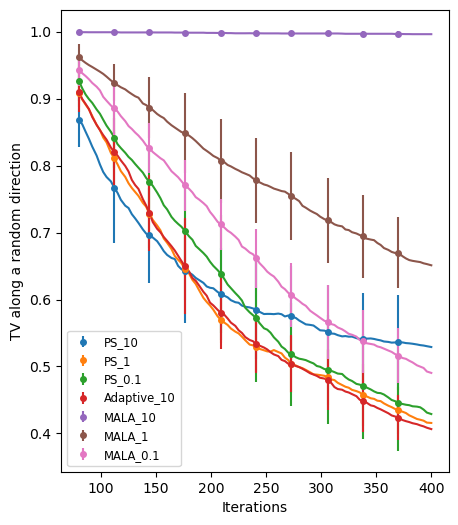

max of std size:0.3125


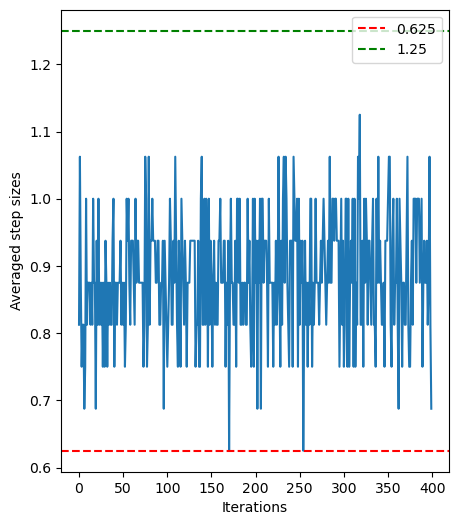

In [6]:

def Mixture_Gaussian_sampler(seed, dimension, numIter, numSamples, initialStep):
    random.seed(seed)
    np.random.seed(seed)

    Target = target_func(dimension, if_simple=False)
    
    # To Do: double check this formula
    hatC = (1 + Target.alpha) * (1 / Target.alpha)**(Target.alpha / (1 + Target.alpha)) * (1 / np.pi)**(2 / (1 + Target.alpha)) * 2**((-1 - 2 * Target.alpha) / (1 + Target.alpha))
    min_step_size = hatC / (120 * np.log(6 / 0.01) / np.log(2) * Target.L_alpha * np.sqrt(Target.dimension))
    print(f"min_step_size={min_step_size}")

    Xsamples_fixed_1 = proximal_sampler(10, numSamples, numIter, f=Target, fixed=True)
    Xsamples_fixed_2 = proximal_sampler(1, numSamples, numIter, f=Target, fixed=True)
    Xsamples_fixed_3 = proximal_sampler(0.1, numSamples, numIter, f=Target, fixed=True)
    Xsamples_adaptive, step_sizes = proximal_sampler(initialStep, numSamples, numIter, f=Target, fixed=False)
    
    Xsamples_MALA_1 = MALA(Target, 10, numIter, numSamples)
    Xsamples_MALA_2 = MALA(Target, 1, numIter, numSamples)
    Xsamples_MALA_3 = MALA(Target, 0.1, numIter, numSamples)

    direction = np.random.multivariate_normal(mean=np.zeros(dimension), cov=np.identity(dimension), size=1)
    direction = np.transpose(direction) / np.linalg.norm(direction, ord=2)
    
    realSamples = np.zeros([200000, dimension])
    for i in range(np.shape(realSamples)[0]):
        realSamples[i, :] = Target.samplesTarget()
    
    bin_num = 500
    histY, bin_edges_Y = np.histogram(np.matmul(realSamples, direction), bins=bin_num, density=True)

    num_iter = numIter
    number_samples_hist = int(0.2 * num_iter)
    min_number_samples_hist = int(0.1 * num_iter)
    number_hist = 100
    bin_size = int((number_samples_hist - min_number_samples_hist) / 100)
    index_hist = np.linspace(number_samples_hist, num_iter, number_hist).astype(int)

    def calculate_distances(Xsamples):
        distances_random = np.zeros(number_hist)
        projected_sample_random = np.matmul(Xsamples, direction)
        for i in range(number_hist):
            distances_random[i] = TV_estimation(projected_sample_random[0, min_number_samples_hist:index_hist[i]], histY, bin_edges_Y, bin_num)
        return 0.5 * distances_random

    results = {
        'PS_10': calculate_distances(Xsamples_fixed_1),
        'PS_1': calculate_distances(Xsamples_fixed_2),
        'PS_0.1': calculate_distances(Xsamples_fixed_3),
        'Adaptive_10': calculate_distances(Xsamples_adaptive),
        'MALA_10': calculate_distances(Xsamples_MALA_1),
        'MALA_1': calculate_distances(Xsamples_MALA_2),
        'MALA_0.1': calculate_distances(Xsamples_MALA_3)
    }

    return results, step_sizes, index_hist

def run_experiments(seeds, dimension, numIter, numSamples, initialStep):
    all_results = {
        'PS_10': [],
        'PS_1': [],
        'PS_0.1': [],
        'Adaptive_10': [],
        'MALA_10': [],
        'MALA_1': [],
        'MALA_0.1': []
    }
    all_step_sizes = []

    for seed in seeds:
        results, step_sizes, index_hist = Mixture_Gaussian_sampler(seed, dimension, numIter, numSamples, initialStep)
        for key in results:
            all_results[key].append(results[key])
        all_step_sizes.append(step_sizes)
    
    mean_results = {}
    std_results = {}
    for key in all_results:
        mean_results[key] = np.mean(all_results[key], axis=0)
        std_results[key] = np.std(all_results[key], axis=0)
    
    mean_step_sizes = np.mean(all_step_sizes, axis=0)
    std_step_sizes = np.std(all_step_sizes, axis=0)

    np.save('Mixture_Gaussian_TV.npy', all_results)
    np.save('Mixture_Gaussian_size.npy', all_step_sizes)
    
    return mean_results, std_results, index_hist, mean_step_sizes, std_step_sizes

seeds = [i for i in range(10)]
dimension = 2
numIter = 400
numSamples = 1
initialStep = 10

mean_results, std_results, index_hist, mean_step_sizes, std_step_sizes = run_experiments(seeds, dimension, numIter, numSamples, initialStep)

plt.figure(figsize=(5, 6))
for key in mean_results:
    line, = plt.plot(index_hist, mean_results[key])
    temp_mean = mean_results[key]
    temp_std = std_results[key]
    plt.errorbar(index_hist[np.arange(0, len(index_hist), 10)], temp_mean[np.arange(0, len(index_hist), 10)], 
                 yerr=2*temp_std[np.arange(0, len(index_hist), 10)], label=key, fmt='o', color = line.get_color(),markersize=4)

    
plt.xlabel('Iterations')
plt.ylabel('TV along a random direction')
plt.legend(fontsize='small', loc='lower left')
plt.savefig('Mixture_Gaussian_TV.pdf')
plt.show()
plt.close()

plt.figure(figsize=(5, 6))
mean_step = mean_step_sizes[0,:]
plt.plot(range(len(mean_step)), mean_step)
print(f'max of std size:{max(std_step_sizes[0,:])}')
plt.xlabel('Iterations')
plt.ylabel('Averaged step sizes')
plt.axhline(y=0.625, linestyle='--', label='0.625', color='r')
plt.axhline(y=1.25, linestyle='--', label='1.25', color='g')
plt.legend()
plt.savefig('Mixture_Gaussian_size.pdf')
plt.show()
plt.close()


/home/byuan48/code/AdaptiveSampling/targets.py:28: RuntimeWarning: invalid value encountered in divide
  self.mean = np.matmul(self.means,self.probs) / np.inner(self.probs, integrals)


L=3.7553359178889756
min_step_size=3.826872390173408e-05
fixed sampling
1.1196826262745094
Steps:100
Averaged rejection steps : 2.0
Steps:200
Averaged rejection steps : 1.0
Steps:300
Averaged rejection steps : 1.0
fixed sampling
Steps:100
Averaged rejection steps : 1.0
Steps:200
Averaged rejection steps : 4.0
Steps:300
Averaged rejection steps : 2.0
fixed sampling
0.0033740414379458176
Steps:100
Averaged rejection steps : 1.0
Steps:200
Averaged rejection steps : 2.0
Steps:300
Averaged rejection steps : 1.0
adpative sampling
Steps:100
Averaged_step_size:1.25
Averaged rejection steps : 2.0
0.0012312425624900552
Steps:200
Averaged_step_size:0.625
Averaged rejection steps : 1.0
Steps:300
Averaged_step_size:0.625
Averaged rejection steps : 2.0
0.005335958417332575
L=4.989898092763681
min_step_size=2.8800570818944872e-05
fixed sampling
Steps:100
Averaged rejection steps : 1.0
Steps:200
Averaged rejection steps : 2.0
0.0024302309231397524
Steps:300
Averaged rejection steps : 3.0


/tmp/ipykernel_404842/120292550.py:12: RuntimeWarning: overflow encountered in exp
  rho = np.exp(b-a)


fixed sampling
Steps:100
Averaged rejection steps : 1.0
Steps:200
Averaged rejection steps : 2.0
Steps:300
Averaged rejection steps : 1.0
fixed sampling
Steps:100
Averaged rejection steps : 1.0
Steps:200
Averaged rejection steps : 2.0
Steps:300
Averaged rejection steps : 5.0
0.003662104216655959
adpative sampling


/tmp/ipykernel_404842/120292550.py:24: RuntimeWarning: overflow encountered in exp
  testFunction = lambda C : np.mean(np.exp(np.abs(Y)**(2/(1+f.alpha))/C))-2


Steps:100
Averaged_step_size:2.5
Averaged rejection steps : 4.0
Steps:200
Averaged_step_size:0.625
Averaged rejection steps : 1.0
Steps:300
Averaged_step_size:1.25
Averaged rejection steps : 1.0
5.0819298074408535e-05
L=3.835975062128178
min_step_size=3.746424600587152e-05
fixed sampling
Steps:100
Averaged rejection steps : 1.0
Steps:200
Averaged rejection steps : 1.0
Steps:300
Averaged rejection steps : 1.0
fixed sampling
Steps:100
Averaged rejection steps : 1.0
Steps:200
Averaged rejection steps : 4.0
Steps:300
Averaged rejection steps : 1.0
fixed sampling
Steps:100
Averaged rejection steps : 4.0
Steps:200
Averaged rejection steps : 1.0
Steps:300
Averaged rejection steps : 1.0
adpative sampling
Steps:100
Averaged_step_size:0.3125
Averaged rejection steps : 3.0
Steps:200
Averaged_step_size:1.25
Averaged rejection steps : 3.0
Steps:300
Averaged_step_size:0.625
Averaged rejection steps : 4.0
L=4.690282348254114
min_step_size=3.0640354402854426e-05
fixed sampling
Steps:100
Averaged rejec

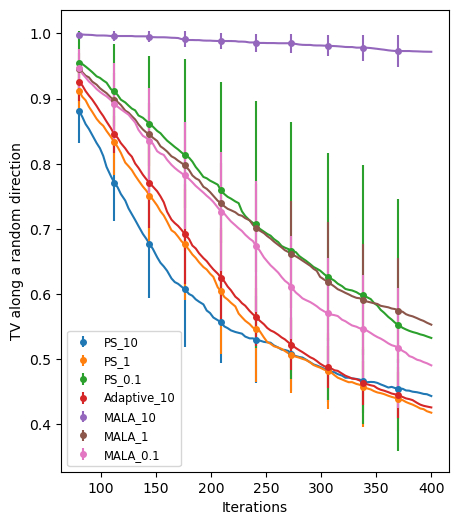

max of std size:0.8028270361665706


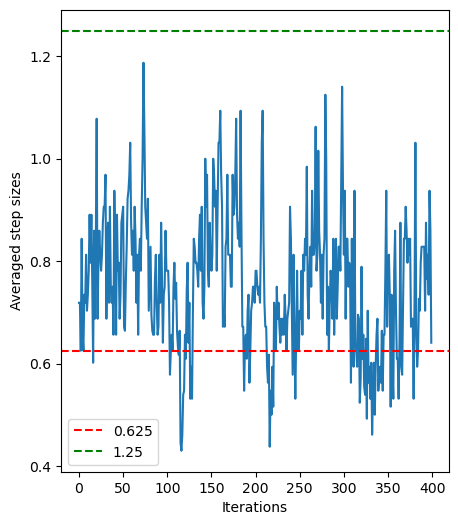

In [8]:
def funnel_sampler(seed, dimension, numIter, numSamples, initialStep):
    random.seed(seed)
    np.random.seed(seed)

    Target = target_funnel()
    
    # To Do: double check this formula
    hatC = (1 + Target.alpha) * (1 / Target.alpha)**(Target.alpha / (1 + Target.alpha)) * (1 / np.pi)**(2 / (1 + Target.alpha)) * 2**((-1 - 2 * Target.alpha) / (1 + Target.alpha))
    min_step_size = hatC / (120 * np.log(6 / 0.01) / np.log(2) * Target.L_alpha * np.sqrt(Target.dimension))
    print(f"min_step_size={min_step_size}")

    Xsamples_fixed_1 = proximal_sampler(10, numSamples, numIter, f=Target, fixed=True)
    Xsamples_fixed_2 = proximal_sampler(1, numSamples, numIter, f=Target, fixed=True)
    Xsamples_fixed_3 = proximal_sampler(0.1, numSamples, numIter, f=Target, fixed=True)
    Xsamples_adaptive, step_sizes = proximal_sampler(initialStep, numSamples, numIter, f=Target, fixed=False)
    
    Xsamples_MALA_1 = MALA(Target, 10, numIter, numSamples)
    Xsamples_MALA_2 = MALA(Target, 1, numIter, numSamples)
    Xsamples_MALA_3 = MALA(Target, 0.1, numIter, numSamples)

    direction = np.random.multivariate_normal(mean=np.zeros(dimension), cov=np.identity(dimension), size=1)
    direction = np.transpose(direction) / np.linalg.norm(direction, ord=2)
    
    realSamples = np.zeros([200000, dimension])
    for i in range(np.shape(realSamples)[0]):
        realSamples[i, :] = Target.samplesTarget()
    
    bin_num = 500
    histY, bin_edges_Y = np.histogram(np.matmul(realSamples, direction), bins=bin_num, density=True)

    num_iter = numIter
    number_samples_hist = int(0.2 * num_iter)
    min_number_samples_hist = int(0.1 * num_iter)
    number_hist = 100
    bin_size = int((number_samples_hist - min_number_samples_hist) / 100)
    index_hist = np.linspace(number_samples_hist, num_iter, number_hist).astype(int)

    def calculate_distances(Xsamples):
        distances_random = np.zeros(number_hist)
        projected_sample_random = np.matmul(Xsamples, direction)
        for i in range(number_hist):
            distances_random[i] = TV_estimation(projected_sample_random[0, min_number_samples_hist:index_hist[i]], histY, bin_edges_Y, bin_num)
        return 0.5 * distances_random

    results = {
        'PS_10': calculate_distances(Xsamples_fixed_1),
        'PS_1': calculate_distances(Xsamples_fixed_2),
        'PS_0.1': calculate_distances(Xsamples_fixed_3),
        'Adaptive_10': calculate_distances(Xsamples_adaptive),
        'MALA_10': calculate_distances(Xsamples_MALA_1),
        'MALA_1': calculate_distances(Xsamples_MALA_2),
        'MALA_0.1': calculate_distances(Xsamples_MALA_3)
    }

    return results, step_sizes, index_hist

def run_experiments(seeds, dimension, numIter, numSamples, initialStep):
    all_results = {
        'PS_10': [],
        'PS_1': [],
        'PS_0.1': [],
        'Adaptive_10': [],
        'MALA_10': [],
        'MALA_1': [],
        'MALA_0.1': []
    }
    all_step_sizes = []

    for seed in seeds:
        results, step_sizes, index_hist = funnel_sampler(seed, dimension, numIter, numSamples, initialStep)
        for key in results:
            all_results[key].append(results[key])
        all_step_sizes.append(step_sizes)
    
    mean_results = {}
    std_results = {}
    for key in all_results:
        mean_results[key] = np.mean(all_results[key], axis=0)
        std_results[key] = np.std(all_results[key], axis=0)
    
    mean_step_sizes = np.mean(all_step_sizes, axis=0)
    std_step_sizes = np.std(all_step_sizes, axis=0)

    np.save('funnel_TV.npy', all_results)
    np.save('funnel_size.npy', all_step_sizes)
    
    return mean_results, std_results, index_hist, mean_step_sizes, std_step_sizes

seeds = [i for i in range(10)]
dimension = 2
numIter = 400
numSamples = 1
initialStep = 10

mean_results, std_results, index_hist, mean_step_sizes, std_step_sizes = run_experiments(seeds, dimension, numIter, numSamples, initialStep)

plt.figure(figsize=(5, 6))
for key in mean_results:
    line, = plt.plot(index_hist, mean_results[key])
    temp_mean = mean_results[key]
    temp_std = std_results[key]
    plt.errorbar(index_hist[np.arange(0, len(index_hist), 10)], temp_mean[np.arange(0, len(index_hist), 10)], 
                 yerr=2*temp_std[np.arange(0, len(index_hist), 10)], label=key, fmt='o', color = line.get_color(),markersize=4)

    
plt.xlabel('Iterations')
plt.ylabel('TV along a random direction')
plt.legend(fontsize='small', loc='lower left')
plt.savefig('funnel_TV.pdf')
plt.show()
plt.close()

plt.figure(figsize=(5, 6))
mean_step = mean_step_sizes[0,:]
plt.plot(range(len(mean_step)), mean_step)
print(f'max of std size:{max(std_step_sizes[0,:])}')
plt.xlabel('Iterations')
plt.ylabel('Averaged step sizes')
plt.axhline(y=0.625, linestyle='--', label='0.625', color='r')
plt.axhline(y=1.25, linestyle='--', label='1.25', color='g')
plt.legend()
plt.savefig('funnel_size.pdf')
plt.show()
plt.close()


In [ ]:
# def Mixture_Gaussian_sampler(seed, dimension, numIter, numSamples, initialStep):

#     random.seed(seed)
#     np.random.seed(seed)

#     Target = target_func(dimension, if_simple = False)
    
#     # To Do: double check this formula
#     hatC = (1+Target.alpha)*(1/Target.alpha)**(Target.alpha/(1+Target.alpha))*(1/np.pi)**(2/(1+Target.alpha))*2**((-1-2*Target.alpha)/(1+Target.alpha))
#     min_step_size = hatC/(120*np.log(6/0.01)/np.log(2)*Target.L_alpha*np.sqrt(Target.dimension))
#     print(f"min_step_size={min_step_size}")
    
#     # step size = 0.1 is good enough
#     # RGO with fixed step size, the initial large one
    
#     Xsamples_fixed_1 = proximal_sampler(10, numSamples, numIter, f = Target, fixed = True) 
#     Xsamples_fixed_2 = proximal_sampler(1, numSamples, numIter, f = Target, fixed = True) 
#     Xsamples_fixed_3 = proximal_sampler(0.1, numSamples, numIter, f = Target, fixed = True) 
#     Xsamples_adaptive ,step_sizes = proximal_sampler(initialStep, numSamples, numIter, f = Target, fixed = False)
    
#     Xsamples_MALA_1 = MALA(Target, 10, numIter, numSamples)
#     Xsamples_MALA_2 = MALA(Target, 1, numIter, numSamples)
#     Xsamples_MALA_3 = MALA(Target, 0.1, numIter, numSamples)
    
    
#     direction = np.random.multivariate_normal(mean = np.zeros(dimension), cov =  np.identity(dimension), size = 1)
#     direction = np.transpose(direction) / np.linalg.norm(direction, ord = 2)
#     # 0. True density
#     realSamples = np.zeros([200000, dimension])
#     for i in range(np.shape(realSamples)[0]):
#             realSamples[i,:] = Target.samplesTarget()
#     bin_num = 500
#     plt.hist(np.matmul(realSamples,direction), bins=bin_num, edgecolor='black', density=True, fill=False)
#     plt.savefig(f"true_density.png")
#     plt.close()
    
#     # 2.1 Discrete TV on a random direction 
#     num_iter = numIter
#     number_samples_hist = int(0.2 * num_iter)
#     min_number_samples_hist = int(0.1 * num_iter)
#     number_hist = 100
#     # Not the precise bin_size but it doesn't matter
#     bin_size = int((number_samples_hist-min_number_samples_hist) / 100 )
#     index_hist = np.linspace(number_samples_hist, num_iter, number_hist)
#     index_hist = index_hist.astype(int)
    
#     projected_sample = np.matmul(realSamples,direction)
#     histY, bin_edges_Y = np.histogram(projected_sample, bins=bin_num, density=True)
    
    
#     plt.figure(figsize=(5,7.5))
    
#     distances_random = np.zeros(number_hist)
#     projected_sample_random = np.matmul(Xsamples_fixed_1,direction)
#     for i in range(number_hist):
#         distances_random[i] = TV_estimation(projected_sample_random[0,min_number_samples_hist:index_hist[i]], histY, bin_edges_Y, bin_num)
#     plt.plot(index_hist,0.5*distances_random, label = 'PS, step size 10')
    
#     distances_random = np.zeros(number_hist)
#     projected_sample_random = np.matmul(Xsamples_fixed_2,direction)
#     for i in range(number_hist):
#         distances_random[i] = TV_estimation(projected_sample_random[0,min_number_samples_hist:index_hist[i]], histY, bin_edges_Y, bin_num)
#     plt.plot(index_hist, 0.5*distances_random, label = 'PS, step size 1')
    
#     distances_random = np.zeros(number_hist)
#     projected_sample_random = np.matmul(Xsamples_fixed_3,direction)
#     for i in range(number_hist):
#         distances_random[i] = TV_estimation(projected_sample_random[0,min_number_samples_hist:index_hist[i]], histY, bin_edges_Y, bin_num)
#     plt.plot(index_hist, 0.5*distances_random, label = 'PS, step size 0.1')
    
#     distances_random = np.zeros(number_hist)
#     projected_sample_random = np.matmul(Xsamples_adaptive,direction)
#     for i in range(number_hist):
#         distances_random[i] = TV_estimation(projected_sample_random[0,min_number_samples_hist:index_hist[i]], histY, bin_edges_Y, bin_num)
#     plt.plot(index_hist, 0.5*distances_random, label = 'adpative, intial 10')
    
#     distances_random = np.zeros(number_hist)
#     projected_sample_random = np.matmul(Xsamples_MALA_1,direction)
#     for i in range(number_hist):
#         distances_random[i] = TV_estimation(projected_sample_random[0,min_number_samples_hist:index_hist[i]], histY, bin_edges_Y, bin_num)
#     plt.plot(index_hist, 0.5*distances_random, linestyle='dashed', label = 'MALA, step size 10')
    
    
#     distances_random = np.zeros(number_hist)
#     projected_sample_random = np.matmul(Xsamples_MALA_2,direction)
#     for i in range(number_hist):
#         distances_random[i] = TV_estimation(projected_sample_random[0,min_number_samples_hist:index_hist[i]], histY, bin_edges_Y, bin_num)
#     plt.plot(index_hist, 0.5*distances_random, linestyle='dashed', label = 'MALA, step size 1')
    
    
#     distances_random = np.zeros(number_hist)
#     projected_sample_random = np.matmul(Xsamples_MALA_3,direction)
#     for i in range(number_hist):
#         distances_random[i] = TV_estimation(projected_sample_random[0,min_number_samples_hist:index_hist[i]], histY, bin_edges_Y, bin_num)
#     plt.plot(index_hist, 0.5*distances_random, linestyle='dashed', label = 'MALA, step size 0.1')
    
    
#     plt.xlabel('Iterations')
#     plt.ylabel('TV along a random direction')
#     plt.legend(fontsize = 'small', loc = 'lower left')
#     plt.savefig(f'{seed}_GaussianMixture.pdf')
#     plt.show()
#     plt.close()
#     if Target.times1 > 0:
#         print(f"# of calls of built-in: {Target.times1}")
#     if Target.times2 > 0:
#         print(f"Averaged optimization steps of the new one: {Target.ite2/Target.times2}")
#         print(f"# of calls of the new one: {Target.times2}")
#     print(f"dimension:{dimension}")
#     print(f"alpha:{Target.alpha}")
#     # print(f"length:{Target.components}")
#     # print(f"eigenvalues:{1/max(eigenvalues)} and {1/min(eigenvalues)}")
    
#     return step_sizes

# step_sizes = Gaussian_sampler(000, 50, 400, 1, 10)
# step_sizes = step_sizes[0,:]
# plt.figure(figsize=(5,7.5))
# print(step_sizes)
# plt.plot(step_sizes)
# plt.xlabel('Iterations')
# plt.ylabel('Step size')
# plt.yscale('log')
# plt.axhline(y=0.625,linestyle = '--', label = '0.625', color = 'r')
# plt.axhline(y=0.3125,linestyle = '--', label = '0.3125', color = 'g')
# plt.legend()
# plt.savefig(f'{000}_size_Mixture.pdf')
# plt.show()
# plt.close()

In [ ]:
# def funnel_sampler(seed, dimension, numIter, numSamples, initialStep):

#     random.seed(seed)
#     np.random.seed(seed)

#     Target = target_funnel()
    
#     # To Do: double check this formula
#     hatC = (1+Target.alpha)*(1/Target.alpha)**(Target.alpha/(1+Target.alpha))*(1/np.pi)**(2/(1+Target.alpha))*2**((-1-2*Target.alpha)/(1+Target.alpha))
#     min_step_size = hatC/(120*np.log(6/0.01)/np.log(2)*Target.L_alpha*np.sqrt(Target.dimension))
#     print(f"min_step_size={min_step_size}")
    
#     # step size = 0.1 is good enough
#     # RGO with fixed step size, the initial large one
    
#     Xsamples_fixed_1 = proximal_sampler(10, numSamples, numIter, f = Target, fixed = True) 
#     Xsamples_fixed_2 = proximal_sampler(1, numSamples, numIter, f = Target, fixed = True) 
#     Xsamples_fixed_3 = proximal_sampler(0.1, numSamples, numIter, f = Target, fixed = True) 
#     Xsamples_adaptive ,step_sizes = proximal_sampler(initialStep, numSamples, numIter, f = Target, fixed = False)
    
#     Xsamples_MALA_1 = MALA(Target, 10, numIter, numSamples)
#     Xsamples_MALA_2 = MALA(Target, 1, numIter, numSamples)
#     Xsamples_MALA_3 = MALA(Target, 0.1, numIter, numSamples)
    
    
#     direction = np.random.multivariate_normal(mean = np.zeros(dimension), cov =  np.identity(dimension), size = 1)
#     direction = np.transpose(direction) / np.linalg.norm(direction, ord = 2)
#     # 0. True density
#     realSamples = np.zeros([200000, dimension])
#     for i in range(np.shape(realSamples)[0]):
#             realSamples[i,:] = Target.samplesTarget()
#     bin_num = 500
#     plt.hist(np.matmul(realSamples,direction), bins=bin_num, edgecolor='black', density=True, fill=False)
#     plt.savefig(f"true_density.png")
#     plt.close()
    
#     # 2.1 Discrete TV on a random direction 
#     num_iter = numIter
#     number_samples_hist = int(0.2 * num_iter)
#     min_number_samples_hist = int(0.1 * num_iter)
#     number_hist = 100
#     # Not the precise bin_size but it doesn't matter
#     bin_size = int((number_samples_hist-min_number_samples_hist) / 100 )
#     index_hist = np.linspace(number_samples_hist, num_iter, number_hist)
#     index_hist = index_hist.astype(int)
    
#     projected_sample = np.matmul(realSamples,direction)
#     histY, bin_edges_Y = np.histogram(projected_sample, bins=bin_num, density=True)
    
    
#     plt.figure(figsize=(5,7.5))
    
#     distances_random = np.zeros(number_hist)
#     projected_sample_random = np.matmul(Xsamples_fixed_1,direction)
#     for i in range(number_hist):
#         distances_random[i] = TV_estimation(projected_sample_random[0,min_number_samples_hist:index_hist[i]], histY, bin_edges_Y, bin_num)
#     plt.plot(index_hist,0.5*distances_random, label = 'PS, step size 10')
    
#     distances_random = np.zeros(number_hist)
#     projected_sample_random = np.matmul(Xsamples_fixed_2,direction)
#     for i in range(number_hist):
#         distances_random[i] = TV_estimation(projected_sample_random[0,min_number_samples_hist:index_hist[i]], histY, bin_edges_Y, bin_num)
#     plt.plot(index_hist, 0.5*distances_random, label = 'PS, step size 1')
    
#     distances_random = np.zeros(number_hist)
#     projected_sample_random = np.matmul(Xsamples_fixed_3,direction)
#     for i in range(number_hist):
#         distances_random[i] = TV_estimation(projected_sample_random[0,min_number_samples_hist:index_hist[i]], histY, bin_edges_Y, bin_num)
#     plt.plot(index_hist, 0.5*distances_random, label = 'PS, step size 0.1')
    
#     distances_random = np.zeros(number_hist)
#     projected_sample_random = np.matmul(Xsamples_adaptive,direction)
#     for i in range(number_hist):
#         distances_random[i] = TV_estimation(projected_sample_random[0,min_number_samples_hist:index_hist[i]], histY, bin_edges_Y, bin_num)
#     plt.plot(index_hist, 0.5*distances_random, label = 'adpative, intial 10')
    
#     distances_random = np.zeros(number_hist)
#     projected_sample_random = np.matmul(Xsamples_MALA_1,direction)
#     for i in range(number_hist):
#         distances_random[i] = TV_estimation(projected_sample_random[0,min_number_samples_hist:index_hist[i]], histY, bin_edges_Y, bin_num)
#     plt.plot(index_hist, 0.5*distances_random, linestyle='dashed', label = 'MALA, step size 10')
    
    
#     distances_random = np.zeros(number_hist)
#     projected_sample_random = np.matmul(Xsamples_MALA_2,direction)
#     for i in range(number_hist):
#         distances_random[i] = TV_estimation(projected_sample_random[0,min_number_samples_hist:index_hist[i]], histY, bin_edges_Y, bin_num)
#     plt.plot(index_hist, 0.5*distances_random, linestyle='dashed', label = 'MALA, step size 1')
    
    
#     distances_random = np.zeros(number_hist)
#     projected_sample_random = np.matmul(Xsamples_MALA_3,direction)
#     for i in range(number_hist):
#         distances_random[i] = TV_estimation(projected_sample_random[0,min_number_samples_hist:index_hist[i]], histY, bin_edges_Y, bin_num)
#     plt.plot(index_hist, 0.5*distances_random, linestyle='dashed', label = 'MALA, step size 0.1')
    
    
#     plt.xlabel('Iterations')
#     plt.ylabel('TV along a random direction')
#     plt.legend(fontsize = 'small', loc = 'lower left')
#     plt.savefig(f'{seed}_funnel.pdf')
#     plt.show()
#     plt.close()
#     if Target.times1 > 0:
#         print(f"# of calls of built-in: {Target.times1}")
#     if Target.times2 > 0:
#         print(f"Averaged optimization steps of the new one: {Target.ite2/Target.times2}")
#         print(f"# of calls of the new one: {Target.times2}")
#     print(f"dimension:{dimension}")
#     print(f"alpha:{Target.alpha}")
#     # print(f"length:{Target.components}")
#     # print(f"eigenvalues:{1/max(eigenvalues)} and {1/min(eigenvalues)}")
    
#     return step_sizes

# step_sizes = funnel_sampler(10, 2, 400, 1, 10)
# step_sizes = step_sizes[0,:]
# plt.figure(figsize=(5,7.5))
# print(step_sizes)
# plt.plot(step_sizes)
# plt.xlabel('Iterations')
# plt.ylabel('Step size')
# plt.yscale('log')

# plt.axhline(y=2.5,linestyle = '--', label = '2.5', color = 'm')
# plt.axhline(y=1.25,linestyle = '--', label = '1.25', color = 'b')
# plt.axhline(y=0.625,linestyle = '--', label = '0.625', color = 'r')
# plt.axhline(y=0.3125,linestyle = '--', label = '0.3125', color = 'g')
# plt.axhline(y=0.15625,linestyle = '--', label = '0.15625', color = 'y')
# plt.legend()
# plt.savefig(f'{10}_size_funnel.pdf')
# plt.show()
# plt.close()